# Подготовительный этап

### Подключение библиотек

In [2]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import copy
from time import time

# вспомогательные функции
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# аугментация данных
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

Установим optuna

In [3]:
%%capture
! pip install optuna
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler

Установим CatBoostClassifier

In [4]:
%%capture
! pip install catboost
from catboost import CatBoostClassifier

### Загрузка датасета

In [5]:
df = pd.read_csv('hmeq.csv')

Рассмотрим данные таблицы:

In [6]:
df

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,DebtCon,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,89000,54576.0,92937.0,DebtCon,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,89200,54045.0,92924.0,DebtCon,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,89800,50370.0,91861.0,DebtCon,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


Для начала давайте рассмотрим длю пропусков в каждой колонке:

In [7]:
df.isna().mean(axis=0)

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

# Работа с данными

При рассмотрении этих данных стоит учитывать тот факт, что все эти заявки - кредиты, уже одобренные прошлым алгоритмом. Из-за этого отличия в данных говорят скорее не об особенностях клиентов, а о предвзятостях существующей модели.

### Графики распределения по признакам

**Числовые признаки**

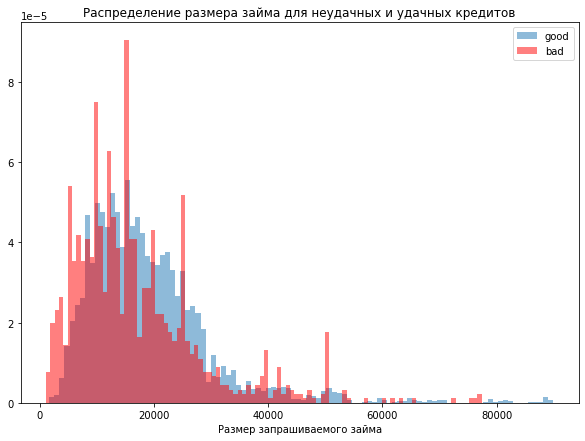

In [8]:
plt.figure(figsize=(10, 7))
plt.hist(df['LOAN'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['LOAN'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Размер запрашиваемого займа')
plt.title('Распределение размера займа для неудачных и удачных кредитов')
plt.show()

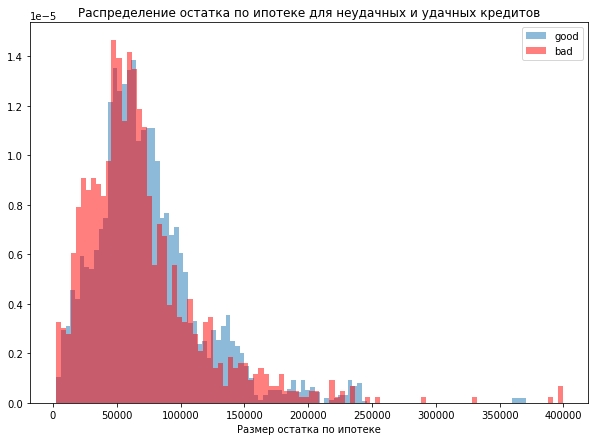

In [9]:
plt.figure(figsize=(10, 7))

plt.hist(df['MORTDUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['MORTDUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Размер остатка по ипотеке')
plt.title('Распределение остатка по ипотеке для неудачных и удачных кредитов')

plt.show()

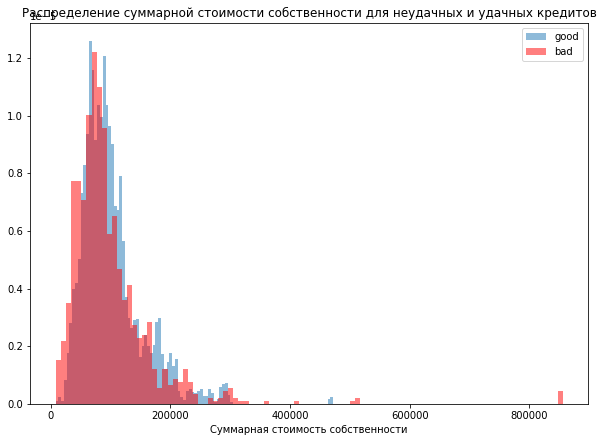

In [10]:
plt.figure(figsize=(10, 7))

plt.hist(df['VALUE'][df['BAD'] == 0], bins=100, alpha=0.5, label='good', density=True)
plt.hist(df['VALUE'][df['BAD'] == 1], bins=100, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Суммарная стоимость собственности')
plt.title('Распределение суммарной стоимости собственности для неудачных и удачных кредитов')

plt.show()

**Категориальные признаки**

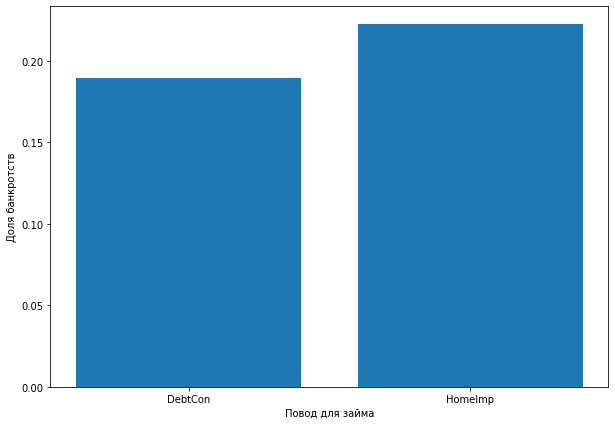

In [11]:
plt.figure(figsize=(10, 7))
plt.bar(x=['DebtCon', 'HomeImp'], height=(df.groupby('REASON').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Повод для займа')
plt.show()

Интуитивно понятно, что реструктуризация долгов - потенциально более рискованная инвестиция, чем покупка для улучшения дома. Возможно прошлые данные овер-компенсировали этот риск, поэтому в нашем датасете реструктуризация статистически надежнее.

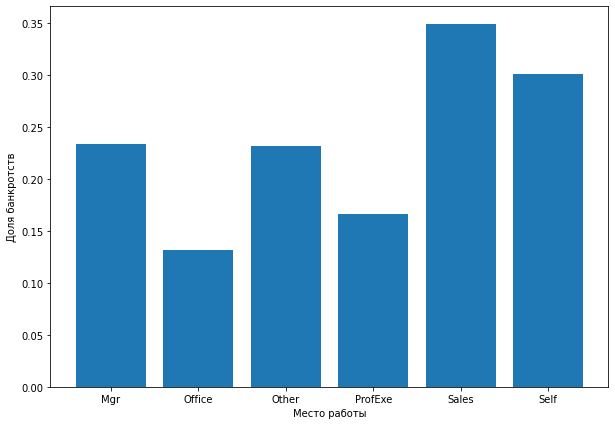

In [12]:
plt.figure(figsize=(10, 7))
plt.bar(x=(df.groupby('JOB').mean()['BAD']).index, height=(df.groupby('JOB').mean()['BAD']))
plt.ylabel('Доля банкротств')
plt.xlabel('Место работы')

plt.show()

### Значимость признаков

Давайте оценим важность признаков с помощью t-статистики, чтобы выделить наиболее значимые для нашей классификации

In [13]:
dfpos = df[df['BAD'] == 0].drop(['BAD', 'JOB', 'REASON'] , axis=1)
dfneg = df[df['BAD'] == 1].drop(['BAD', 'JOB', 'REASON'] , axis=1)
t = np.abs(dfpos.mean(axis=0) - dfneg.mean(axis=0)) / np.sqrt((len(dfpos) * dfpos.std(axis=0)**2 + len(dfneg) * dfneg.std(axis=0)**2)/ (len(dfpos) + len(dfneg)))


In [14]:
t

LOAN       0.188425
MORTDUE    0.120885
VALUE      0.076650
YOJ        0.148999
DEROG      0.715846
DELINQ     0.944193
CLAGE      0.435324
NINQ       0.441615
CLNO       0.010427
DEBTINC    0.609487
dtype: float64

'DEROG', 'DELINQ' - обобщая, эти признаки говорят нам об уже просроченных кредитах. Понятно, почему эти признаки очень важны.

'DEBTINC' - отношение долга к доходу

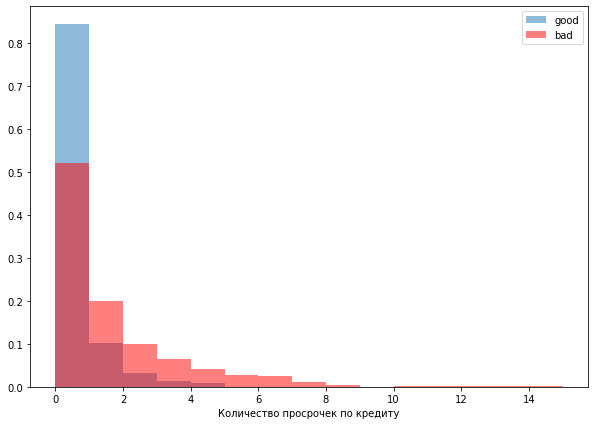

In [15]:
plt.figure(figsize=(10, 7))

plt.hist(df['DELINQ'][df['BAD'] == 0], bins=5, alpha=0.5, label='good', density=True)
plt.hist(df['DELINQ'][df['BAD'] == 1], bins=15, alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Количество просрочек по кредиту')

plt.show()

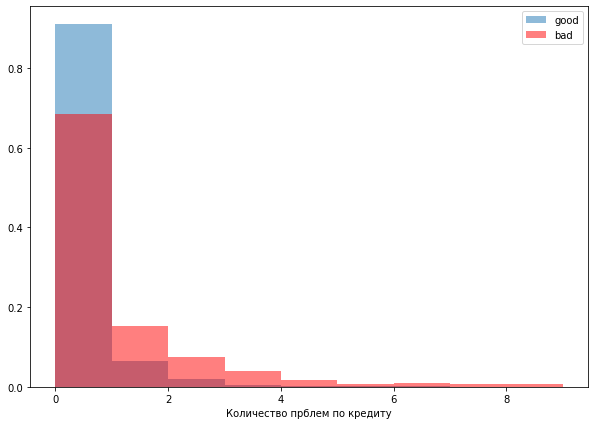

In [16]:
plt.figure(figsize=(10, 7))

plt.hist(df['DEROG'][df['BAD'] == 0], bins=range(10), alpha=0.5, label='good', density=True)
plt.hist(df['DEROG'][df['BAD'] == 1], bins=range(10), alpha=0.5, label='bad', density=True, color='red')
plt.legend()
plt.xlabel('Количество прблем по кредиту')

plt.show()

In [17]:
df['REASON'].value_counts()

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64

In [18]:
df['JOB'].value_counts()

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64

In [19]:
df.isna().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

### Заполнение пропусков

Давайте для начала заполним пропуски в категориальных переменных отдельным значением, в числовых - средним, а переменную с наибольшим количеством пропусков пока удалим.

In [20]:
df_pure = copy.deepcopy(df).drop('DEBTINC', axis=1)
df_pure[['JOB', 'REASON']] = df_pure[['JOB', 'REASON']].fillna('NAN')
df_pure = df_pure.fillna(df_pure.mean(axis=0))

y = df_pure['BAD'].values
X = df_pure.drop("BAD", axis=1).values

Закодируем категориальные переменные

In [21]:
ohe = OneHotEncoder(sparse=False)

In [22]:
X = np.concatenate((X[:, :3], ohe.fit_transform(X[:, [3, 4]]), X[:, 5:]), axis=1)

Разобьем на тренировочные и тестовые данные

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=179)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=179)

Проверим данные

In [24]:
isnatrain, isnatest = train_test_split(df.isna().mean(axis=1), test_size=0.3, random_state=179)

# Вспомогательные функции

Рассмотрим различные критерии, по которым можно сравнить результат работы моделей

### Стандартные критерии



*   accuracy, как удобныая и интерпретируемая, но не всегда информативная метрика
*   площадь под precision-recall кривой
*   площадь по tpr/fpr кривой
*   F-мера



### Вспомогательные критерии 

Реализуем также 

*   Cohen's kappa coefficient (https://en.wikipedia.org/wiki/Cohen%27s_kappa) 

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

*   Matthews correlation coefficient (https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 



In [25]:
def kappa(y0, y1, pos=1, neg=0):
    po = accuracy_score(y0, y1)

    pos0 = (y0 == pos).mean()
    pos1 = (y1 == pos).mean()
    pe = (pos0 * pos1) + (1 - pos0) * (1 - pos1)

    k = (po - pe) / (1 - pe)
    return k

def matthews(pred, target, pos=1, neg=0):
    tp = np.sum((pred == pos) & (target == pos))
    tn = np.sum((pred == neg) & (target == neg))
    fp = np.sum((pred == pos) & (target == neg))
    fn = np.sum((pred == neg) & (target == pos))

    if (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) == 0:
        return 0 # условность, чтобы не вылезало так много nan

    return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

### Бизнес критерий

Было бы логично предположить, что невозврат денег для нас несет больше урона, чем бы нам принесло успешное возвращение. Это говорит нам о том, что порог выдачи кредита стоит выставить ниже чем 0.5 вероятности дефолта

Напишем функцию, которая максимизирует ожидание прибыли, исходя из предположения о том, что наша выгода составляет x% суммы, и если человек не возвращает сумму, он не возвращает ее целиком

In [60]:
def get_prediction(mod, X_test, y_test, x=15):
    y_prob = mod(torch.tensor(X_test).float().cuda()).cpu().numpy().squeeze()
    threshold = (x / 100) / (1 + x / 100)
    y_pred = y_prob > threshold
    return y_pred * 1.0

Введем метрику, которая оценивает лосс как упущенную выгоду, по сравнению с идеальным предсказанием.

In [62]:
def get_gain(y_pred, y_target, loan, x=15):
    return (((y_pred == 1) & (y_target == 1)) * loan - ((y_pred == 1) & (y_target == 0)) * loan * x / 100).sum() / loan.sum()

### Объеденим в функцию

In [28]:
logs = dict()

In [63]:
def rate(mod, X_test, y_test, loans, name="model", x=15):
    y_proba = mod(torch.tensor(X_test).float().cuda()).cpu().numpy().squeeze()
    y_pred = (y_proba > 0.5) * 1
    print("====== " + name + " ======")
    print()
    ac = accuracy_score(y_pred, y_test)
    print(f"Accuracy:\t{accuracy_score(y_pred, y_test)}")
    print(f"Pos/neg ratio:\t{(y_pred == 1).sum() / (y_pred == 0).sum()}")
    print()

    print(f"Kappa coef:\t{kappa(y_pred, y_test)}")
    print(f"Matthews coef:\t{matthews(y_pred, y_test)}")
    print(f"ROC-AUC value:\t{roc_auc_score(y_test, y_proba)}")
    auc_pr = auc(*reversed((precision_recall_curve(y_test, y_proba))[:2]))
    print(f"PR-AUC value:\t{auc_pr}")
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    print()
    print(f"Precision:\t{pr}")
    print(f"Recall: \t{rc}")
    fscore = 2 * pr * rc / (pr + rc)
    print(f"F-score:\t{fscore}")

    loan = loans
    y_pred_financial = get_prediction(mod, X_test, y_test, x=x)
    gains = get_gain(y_pred_financial, y_test, loan, x=x)
    print(f"Financial gain:\t{gains}")
    print()
    print("=======" + '=' * len(name) + "=======")
    return ac, auc_pr, fscore, gains

In [30]:
def string_time(elapsed):
    return "%im %is" %(int(elapsed / 60), int(elapsed % 60))

In [31]:
def run(mod, X_train, y_train, X_test, y_test, name='model', x=15):
    global logs

    start_time = time()
    mod.fit(X_train, y_train)
    end_time = time()
    ac, auc_pr, fscore, gains = rate(mod, X_test, y_test, name=name, x=x)
    elapsed = end_time - start_time
    print("Time elapsed: " + string_time(elapsed))

    logs[name] = [ac, auc_pr, fscore, gains, elapsed, name]

    return mod.predict(X_test)

### Калибровочная кривая

Для оценки результата и внесения корректировок нам также понадобится калибровочная кривая

In [32]:
def calibration_curve(mod, X, y):
    probs = mod.predict_proba(X)[:, 1]
    vals = []
    for prob in np.arange(0, 1, 0.05):
        vals.append(y[(probs >= prob) & (probs < prob + 0.05)].mean())
    plt.plot(np.arange(0, 1, 0.05) + 0.025, vals, label='Our curve')
    plt.plot(np.arange(0, 1, 0.05) + 0.025, np.arange(0, 1, 0.05) + 0.025, label='Perfect curve')
    return vals

def build_calibration_curve(mod, X, y, sz=(10,10)):
    plt.figure(figsize=sz)
    vals = calibration_curve(mod, X, y)
    plt.xlabel('Predicted probability', fontdict={'size':15})
    plt.ylabel('Fraction of positive results for this probability', fontdict={'size':15})
    plt.legend()
    plt.show()

### Разное

In [33]:
def print_vals(d):
    ans = ''
    for key, val in d.items():
        ans += key + '=' + str(val) + ', '
    return ans[:-2]

In [34]:
import torch
import torch.nn as nn

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler().fit(X_train)

In [76]:
model = nn.Sequential(nn.Linear(19, 100), nn.Sigmoid(), nn.Linear(100, 1), nn.Sigmoid())

In [77]:
model = model.cuda()

In [78]:
loss = nn.BCELoss()

In [79]:
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-3)

In [80]:
X_train2 = scaler.transform(np.float64(X_train))
X_test2 = scaler.transform(np.float64(X_test))
X_val2 = scaler.transform(np.float64(X_val))

In [81]:
X_train2 = np.copy(np.float64(X_train))
X_train2 -= X_train2.mean(axis=0)
X_train2 /= X_train2.std(axis=0)

In [82]:
loans = X_val[:, 0]

Подберем коэффициент регуляризации

In [85]:
from sklearn.metrics import roc_auc_score

for lambda_ in [0, 1e-7, 1e-5, 1e-3, 1e-1]:
    model = nn.Sequential(nn.Linear(19, 100), nn.Sigmoid(), nn.Linear(100, 1), nn.Sigmoid())
    model = model.cuda()
    loss = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), weight_decay=lambda_)
    for epoch in range(10000):
        lres = loss(model(torch.tensor(X_train2).float().cuda()), torch.tensor(y_train).float().cuda()[:, None])
        lres.backward()
        opt.step()
        opt.zero_grad()
        with torch.no_grad():
            if (epoch % 100 == 0):
                model.eval()
                acc = ((torch.round(model(torch.tensor(X_val2).float().cuda())) == torch.tensor(y_val).cuda()) * 1.0).mean()
                pred = model(torch.tensor(X_val2).float().cuda()).cpu().numpy()
                prauc = auc(*reversed((precision_recall_curve(y_val, pred))[:2]))
                rate(model, X_val2, y_val, loans)
                print(lambda_, epoch, acc)
                model.train()
                #print(acc.data.item(), roc_auc_score(y_test, pred), prauc, epoch)

====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.018223234624145785

Kappa coef:	0.04538174052322453
Matthews coef:	0.09376348555410094
ROC-AUC value:	0.4233440170940172
PR-AUC value:	0.20601937614902882

Precision:	0.5
Recall: 	0.041666666666666664
F-score:	0.07692307692307693
Financial gain:	0.0722812294970352

0 0 tensor(0.7750, device='cuda:0')
====== model ======

Accuracy:	0.7874720357941835
Pos/neg ratio:	0.002242152466367713

Kappa coef:	0.016262422683994967
Matthews coef:	0.0905420894123664
ROC-AUC value:	0.7763829534662868
PR-AUC value:	0.5299070811943049

Precision:	1.0
Recall: 	0.010416666666666666
F-score:	0.020618556701030924
Financial gain:	0.08911563362671915

0 100 tensor(0.7840, device='cuda:0')
====== model ======

Accuracy:	0.8053691275167785
Pos/neg ratio:	0.03953488372093023

Kappa coef:	0.1769001206425804
Matthews coef:	0.26627139153543056
ROC-AUC value:	0.791755698005698
PR-AUC value:	0.5686596398059598

Precision:	0.7647058823529411
Recall: 	0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.8098434004474273
Pos/neg ratio:	0.054245283018867926

Kappa coef:	0.22104680484654643
Matthews coef:	0.2973947590731466
ROC-AUC value:	0.7912808641975309
PR-AUC value:	0.579542970716257

Precision:	0.7391304347826086
Recall: 	0.17708333333333334
F-score:	0.2857142857142857
Financial gain:	0.10147807033832212

1e-05 200 tensor(0.7559, device='cuda:0')
====== model ======

Accuracy:	0.825503355704698
Pos/neg ratio:	0.07710843373493977

Kappa coef:	0.31731672932330846
Matthews coef:	0.38305190510313447
ROC-AUC value:	0.793150522317189
PR-AUC value:	0.5921330260553916

Precision:	0.78125
Recall: 	0.2604166666666667
F-score:	0.390625
Financial gain:	0.0981951201396368

1e-05 300 tensor(0.7444, device='cuda:0')
====== model ======

Accuracy:	0.8322147651006712
Pos/neg ratio:	0.09024390243902439

Kappa coef:	0.359562152558886
Matthews coef:	0.4162495799657216
ROC-AUC value:	0.7969788698955366
PR-AUC value:	0.604193659794894

Precision:	0.7837837837837838
Recal

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7543625356125356
PR-AUC value:	0.5492431277881636

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7884912155745488
PR-AUC value:	0.5718335359537989

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7971569325735992
PR-AUC value:	0.5695530745095344

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7981956315289649
PR-AUC value:	0.5671166786589139

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7978988603988605
PR-AUC value:	0.5661169440057932

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.798195631528965
PR-AUC value:	0.5664730219544675

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666822561967891

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982104700854701
PR-AUC value:	0.5666605063301053

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7981956315289649
PR-AUC value:	0.56664833100543

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666899648860841

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982401471984805
PR-AUC value:	0.5666823525993249

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982846628679962
PR-AUC value:	0.5667549137451677

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 1900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982401471984805
PR-AUC value:	0.5666823525993249

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 2900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667379911534571

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 3900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667379911534571

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 4900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5667054941954549

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667379911534572

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982846628679962
PR-AUC value:	0.5667549137451676

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 5900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7981956315289649
PR-AUC value:	0.5666639053717217

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666895777933058

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667379911534572

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667379911534571

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 6900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.5666583332481097

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.566705494195455

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5667054941954549

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5666908302061119

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5666583332481097

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419752
PR-AUC value:	0.5666739076144014

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549857
PR-AUC value:	0.5667379911534572

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667224167871655

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 7900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.566705494195455

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7981956315289648
PR-AUC value:	0.5666414106563992

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5667124145444857

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982846628679962
PR-AUC value:	0.5667545341588359

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982846628679962
PR-AUC value:	0.5667425870011452

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.566705494195455

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549857
PR-AUC value:	0.5665307582765133

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982846628679962
PR-AUC value:	0.5667352208287925

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.566729874461493

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667170850801699

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 8900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982846628679962
PR-AUC value:	0.5667464032923601

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9000 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7981956315289648
PR-AUC value:	0.5666714941646258

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982104700854701
PR-AUC value:	0.5665007205756349

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9200 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982549857549858
PR-AUC value:	0.5667371258334295

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9300 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7981659544159544
PR-AUC value:	0.5664734505480897

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9400 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419752
PR-AUC value:	0.5665491711551309

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9500 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982846628679962
PR-AUC value:	0.5667700339038886

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9600 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419754
PR-AUC value:	0.5665196384801049

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9700 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982698243114908
PR-AUC value:	0.5666672938047499

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9800 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7982253086419753
PR-AUC value:	0.566705494195455

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0.1 9900 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



Лучший результат получился для lambda_ = 0. Попробуем модель на тестовой выборке

In [90]:
model = nn.Sequential(nn.Linear(19, 100), nn.Sigmoid(), nn.Linear(100, 1), nn.Sigmoid())
model = model.cuda()
loss = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), weight_decay=0)
for epoch in range(5800):
    lres = loss(model(torch.tensor(X_train2).float().cuda()), torch.tensor(y_train).float().cuda()[:, None])
    lres.backward()
    opt.step()
    opt.zero_grad()
    with torch.no_grad():
        if (epoch % 100 == 0):
            model.eval()
            acc = ((torch.round(model(torch.tensor(X_val2).float().cuda())) == torch.tensor(y_val).cuda()) * 1.0).mean()
            pred = model(torch.tensor(X_val2).float().cuda()).cpu().numpy()
            prauc = auc(*reversed((precision_recall_curve(y_val, pred))[:2]))
            rate(model, X_val2, y_val, loans)
            print(0, epoch, acc)
            model.train()
            #print(acc.data.item(), roc_auc_score(y_test, pred), prauc, epoch)

====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.5804249762583096
PR-AUC value:	0.35573587555363007

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0722812294970352

0 0 tensor(0.7852, device='cuda:0')
====== model ======

Accuracy:	0.7919463087248322
Pos/neg ratio:	0.006756756756756757

Kappa coef:	0.04821759736245595
Matthews coef:	0.1571763083034205
ROC-AUC value:	0.7808345204178538
PR-AUC value:	0.5462991993766335

Precision:	1.0
Recall: 	0.03125
F-score:	0.06060606060606061
Financial gain:	0.09513066191307362

0 100 tensor(0.7814, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.8098434004474273
Pos/neg ratio:	0.054245283018867926

Kappa coef:	0.22104680484654643
Matthews coef:	0.2973947590731466
ROC-AUC value:	0.790301519468186
PR-AUC value:	0.5782164729821396

Precision:	0.7391304347826086
Recall: 	0.17708333333333334
F-score:	0.2857142857142857
Financial gain:	0.10141307980837078

0 200 tensor(0.7559, device='cuda:0')
====== model ======

Accuracy:	0.8232662192393736
Pos/neg ratio:	0.07451923076923077

Kappa coef:	0.3050947517563023
Matthews coef:	0.3718750804785147
ROC-AUC value:	0.7916963437796771
PR-AUC value:	0.5877796057139981

Precision:	0.7741935483870968
Recall: 	0.25
F-score:	0.3779527559055118
Financial gain:	0.09697515504883573

0 300 tensor(0.7457, device='cuda:0')
====== model ======

Accuracy:	0.8277404921700223
Pos/neg ratio:	0.08495145631067962

Kappa coef:	0.336014815672203
Matthews coef:	0.3950904076302106
ROC-AUC value:	0.7939221272554606
PR-AUC value:	0.5988164430688927

Precision:	0.7714285714285715
Reca

In [91]:
loans_test = X_test[:, 0]

In [92]:
with torch.no_grad():
    model.eval()
    rate(model, X_test2, y_test, loans_test)

====== model ======

Accuracy:	0.9530201342281879
Pos/neg ratio:	0.21138211382113822

Kappa coef:	0.8525795053003532
Matthews coef:	0.861997771269917
ROC-AUC value:	0.9704806687565307
PR-AUC value:	0.9488067977990422

Precision:	1.0
Recall: 	0.7878787878787878
F-score:	0.8813559322033898
Financial gain:	0.17523194576398418



Давайте попробуем перебрать размер скрытого слоя:

In [93]:
from sklearn.metrics import roc_auc_score

for wsize in [40, 100, 200, 400, 1000]:
    model = nn.Sequential(nn.Linear(19, wsize), nn.Sigmoid(), nn.Linear(wsize, 1), nn.Sigmoid())
    model = model.cuda()
    loss = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), weight_decay=0)
    for epoch in range(10000):
        lres = loss(model(torch.tensor(X_train2).float().cuda()), torch.tensor(y_train).float().cuda()[:, None])
        lres.backward()
        opt.step()
        opt.zero_grad()
        with torch.no_grad():
            if (epoch % 100 == 0):
                model.eval()
                acc = ((torch.round(model(torch.tensor(X_val2).float().cuda())) == torch.tensor(y_val).cuda()) * 1.0).mean()
                pred = model(torch.tensor(X_val2).float().cuda()).cpu().numpy()
                prauc = auc(*reversed((precision_recall_curve(y_val, pred))[:2]))
                rate(model, X_val2, y_val, loans)
                print(wsize, epoch, acc)
                model.train()
                #print(acc.data.item(), roc_auc_score(y_test, pred), prauc, epoch)

====== model ======

Accuracy:	0.7404921700223713
Pos/neg ratio:	0.12594458438287154

Kappa coef:	0.06844885199956892
Matthews coef:	0.07365895440383162
ROC-AUC value:	0.4908297720797721
PR-AUC value:	0.23518217984147521

Precision:	0.3
Recall: 	0.15625
F-score:	0.20547945205479454
Financial gain:	0.0722812294970352

40 0 tensor(0.7214, device='cuda:0')
====== model ======

Accuracy:	0.785234899328859
Pos/neg ratio:	0.0

Kappa coef:	0.0
Matthews coef:	0
ROC-AUC value:	0.7680733618233619
PR-AUC value:	0.5046722789236713

Precision:	0.0
Recall: 	0.0
F-score:	nan
Financial gain:	0.0816101558534804

40 100 tensor(0.7852, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.7919463087248322
Pos/neg ratio:	0.011312217194570135

Kappa coef:	0.05920293298934021
Matthews coef:	0.15157320450149694
ROC-AUC value:	0.7854047958214625
PR-AUC value:	0.5473533834281568

Precision:	0.8
Recall: 	0.041666666666666664
F-score:	0.07920792079207921
Financial gain:	0.10078483801884107

40 200 tensor(0.7789, device='cuda:0')
====== model ======

Accuracy:	0.8053691275167785
Pos/neg ratio:	0.03953488372093023

Kappa coef:	0.1769001206425804
Matthews coef:	0.26627139153543056
ROC-AUC value:	0.7905092592592592
PR-AUC value:	0.5674989261518005

Precision:	0.7647058823529411
Recall: 	0.13541666666666666
F-score:	0.2300884955752212
Financial gain:	0.09620083930627252

40 300 tensor(0.7635, device='cuda:0')
====== model ======

Accuracy:	0.8120805369127517
Pos/neg ratio:	0.06175771971496437

Kappa coef:	0.242097614145574
Matthews coef:	0.3122605729097212
ROC-AUC value:	0.7925866571699904
PR-AUC value:	0.5809331339138574

Precision:	0.73076923076923

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



====== model ======

Accuracy:	0.8076062639821029
Pos/neg ratio:	0.03233256351039261

Kappa coef:	0.17297018200593803
Matthews coef:	0.2812735615246088
ROC-AUC value:	0.7854047958214625
PR-AUC value:	0.5630888802864216

Precision:	0.8571428571428571
Recall: 	0.125
F-score:	0.21818181818181817
Financial gain:	0.09591054827248982

100 200 tensor(0.7674, device='cuda:0')
====== model ======

Accuracy:	0.8165548098434005
Pos/neg ratio:	0.06682577565632458

Kappa coef:	0.26768161112443106
Matthews coef:	0.3369261938350915
ROC-AUC value:	0.7908357075023741
PR-AUC value:	0.5855366310099216

Precision:	0.75
Recall: 	0.21875
F-score:	0.3387096774193548
Financial gain:	0.10211312065956103

100 300 tensor(0.7495, device='cuda:0')
====== model ======

Accuracy:	0.825503355704698
Pos/neg ratio:	0.07710843373493977

Kappa coef:	0.31731672932330846
Matthews coef:	0.38305190510313447
ROC-AUC value:	0.7934769705603039
PR-AUC value:	0.5932039392122382

Precision:	0.78125
Recall: 	0.2604166666666667
F-sc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in long_scalars



====== model ======

Accuracy:	0.8232662192393736
Pos/neg ratio:	0.07451923076923077

Kappa coef:	0.3050947517563023
Matthews coef:	0.3718750804785147
ROC-AUC value:	0.792824074074074
PR-AUC value:	0.5882965218528498

Precision:	0.7741935483870968
Recall: 	0.25
F-score:	0.3779527559055118
Financial gain:	0.10025810524752107

400 200 tensor(0.7457, device='cuda:0')
====== model ======

Accuracy:	0.825503355704698
Pos/neg ratio:	0.08759124087591241

Kappa coef:	0.330684174153421
Matthews coef:	0.3857386099678303
ROC-AUC value:	0.7954059829059829
PR-AUC value:	0.5992564746744283

Precision:	0.75
Recall: 	0.28125
F-score:	0.4090909090909091
Financial gain:	0.09816355331080329

400 300 tensor(0.7393, device='cuda:0')
====== model ======

Accuracy:	0.8299776286353467
Pos/neg ratio:	0.09290953545232274

Kappa coef:	0.354169043002167
Matthews coef:	0.40704294533364843
ROC-AUC value:	0.7996794871794872
PR-AUC value:	0.6097021627330063

Precision:	0.7631578947368421
Recall: 	0.3020833333333333
F

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in double_scalars



Accuracy:	0.825503355704698
Pos/neg ratio:	0.08232445520581114

Kappa coef:	0.3240665348377344
Matthews coef:	0.3842365796559786
ROC-AUC value:	0.7934769705603039
PR-AUC value:	0.5871555191432833

Precision:	0.7647058823529411
Recall: 	0.2708333333333333
F-score:	0.39999999999999997
Financial gain:	0.09886606999170597

1000 100 tensor(0.7418, device='cuda:0')
====== model ======

Accuracy:	0.825503355704698
Pos/neg ratio:	0.09290953545232274

Kappa coef:	0.3371734915022242
Matthews coef:	0.387510127667074
ROC-AUC value:	0.7973646723646725
PR-AUC value:	0.5977601384860459

Precision:	0.7368421052631579
Recall: 	0.2916666666666667
F-score:	0.41791044776119407
Financial gain:	0.09871318750696327

1000 200 tensor(0.7367, device='cuda:0')
====== model ======

Accuracy:	0.8322147651006712
Pos/neg ratio:	0.09558823529411764

Kappa coef:	0.3657415290311595
Matthews coef:	0.41744112386061155
ROC-AUC value:	0.8049916904083572
PR-AUC value:	0.6194858203941778

Precision:	0.7692307692307693
Recall

Лучшим слоем остается размер 100.

Попробуем обучить модель, добавив больше веса займам большого размера - теоретически, модель должна уделять им больше внимания для выгоды компании. 

In [102]:
model = nn.Sequential(nn.Linear(19, 100), nn.Sigmoid(), nn.Linear(100, 1), nn.Sigmoid())
model = model.cuda()
loss = nn.BCELoss(reduction='none')
opt = torch.optim.Adam(model.parameters(), weight_decay=0)
tsum = torch.tensor(np.float64(X_train[:, 0])).float().sum()
for epoch in range(7000):
    lres = (loss(model(torch.tensor(X_train2).float().cuda()), torch.tensor(y_train).float().cuda()[:, None]) * (torch.tensor(np.float64(X_train[:, 0])).float().cuda() / tsum + 1)).sum()
    lres.backward()
    opt.step()
    opt.zero_grad()
    with torch.no_grad():
        if (epoch % 100 == 0):
            model.eval()
            acc = ((torch.round(model(torch.tensor(X_val2).float().cuda())) == torch.tensor(y_val).cuda()) * 1.0).mean()
            pred = model(torch.tensor(X_val2).float().cuda()).cpu().numpy()
            prauc = auc(*reversed((precision_recall_curve(y_val, pred))[:2]))
            rate(model, X_val2, y_val, loans)
            print(0, epoch, acc)
            model.train()
            #print(acc.data.item(), roc_auc_score(y_test, pred), prauc, epoch)

====== model ======

Accuracy:	0.7315436241610739
Pos/neg ratio:	0.08232445520581114

Kappa coef:	-0.03989763871117785
Matthews coef:	-0.047305508550610435
ROC-AUC value:	0.4285671889838557
PR-AUC value:	0.1815606613914193

Precision:	0.14705882352941177
Recall: 	0.052083333333333336
F-score:	0.07692307692307693
Financial gain:	0.0722812294970352

0 0 tensor(0.7418, device='cuda:0')
====== model ======

Accuracy:	0.7897091722595079
Pos/neg ratio:	0.0044943820224719105

Kappa coef:	0.03233383998894569
Matthews coef:	0.12818964181891968
ROC-AUC value:	0.771545584045584
PR-AUC value:	0.5271338248680116

Precision:	1.0
Recall: 	0.020833333333333332
F-score:	0.04081632653061225
Financial gain:	0.09170473254849532

0 100 tensor(0.7827, device='cuda:0')
====== model ======

Accuracy:	0.8120805369127517
Pos/neg ratio:	0.0468384074941452

Kappa coef:	0.21794551362159478
Matthews coef:	0.30842503679617944
ROC-AUC value:	0.7881350902184234
PR-AUC value:	0.573053828104943

Precision:	0.8
Recall: 	

In [103]:
with torch.no_grad():
    model.eval()
    rate(model, X_test2, y_test, loans_test)

====== model ======

Accuracy:	0.9574944071588367
Pos/neg ratio:	0.21798365122615804

Kappa coef:	0.8676546211023328
Matthews coef:	0.8753545349661981
ROC-AUC value:	0.9546905840009289
PR-AUC value:	0.9450992033922893

Precision:	1.0
Recall: 	0.8080808080808081
F-score:	0.893854748603352
Financial gain:	0.18475784979532472



Полученный результат gain один из лучших для всех моделей, обходя даже некоторые результаты градиентных бустингов.